# Development of machine learning models to process Electronic Health Records – Explainable Models

### Imputation Comparison

Lok Hang Toby Lee (2431180L)

In [2]:
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn import metrics


# SET YOUR PATH FOR RESOURCES FILE HERE
resources_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP\MIMIC-III-ML/data/resources"
data_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP/MIMIC-III-ML/data/raw"


In [3]:
data = pd.read_csv(data_path+'/mimic_timeseries_data_not_imputed.csv')
data = data.drop(['Unnamed: 0'], axis = 1)
# Filter out subjects with length of stay < 48 hours for the in-hospital mortality task:
y = pd.read_hdf(data_path+'/vitals_hourly_data_preprocessed.h5', 'Y')['los']
indices_to_remove = []
for i, row in y.iteritems():
    if row < 48:
        indices_to_remove.append(i)
        
data = data.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
y = y.drop(indices_to_remove, axis = 0)

# Extract only the first 48 hours:
data = data[data['hours_in'] < 48].reset_index().drop('index', axis = 1)


# Imputation results Comparison

In [30]:
mean_imputed=pd.read_csv(data_path+'/imputed_data/mean_imputed.csv')
joint_imputed=pd.read_csv(data_path+'/imputed_data/joint_imputed.csv')
itr_imputed=pd.read_csv(data_path+'/imputed_data/itr_imputed.csv')
knn_imputed=pd.read_csv(data_path+'/imputed_data/knn_imputed.csv')
mice_imputed_2=pd.read_csv(data_path+'/imputed_data/mice_imputed_v2.csv')
midas_imputed=pd.read_csv(data_path+'/imputed_data/midas_imputedv2.csv')

variable_ranges = pd.read_csv(resources_path+ '/variable_ranges.csv', index_col = None)

imputed_data=[data, mean_imputed, joint_imputed, itr_imputed,knn_imputed, mice_imputed_2, midas_imputed]
imputed_labels=['original','mean_imputed', 'joint_imputed', 'itr_imputed','knn_imputed','mice_imputed','midas_imputed']

for i in range(len(imputed_data)):
    for column in imputed_data[i].columns:

        #Remove outliers
        if column in variable_ranges['LEVEL2'].values:
            row = variable_ranges[variable_ranges['LEVEL2']==column]

            highs=imputed_data[i].index[imputed_data[i][column]>row['OUTLIER HIGH'].values[0]].tolist()
            lows = imputed_data[i].index[imputed_data[i][column]<row['OUTLIER LOW'].values[0]].tolist()
            imputed_data[i].loc[highs,column]=row['IMPUTE'].values[0]
            imputed_data[i].loc[lows,column]=row['IMPUTE'].values[0]

### Distribution plot

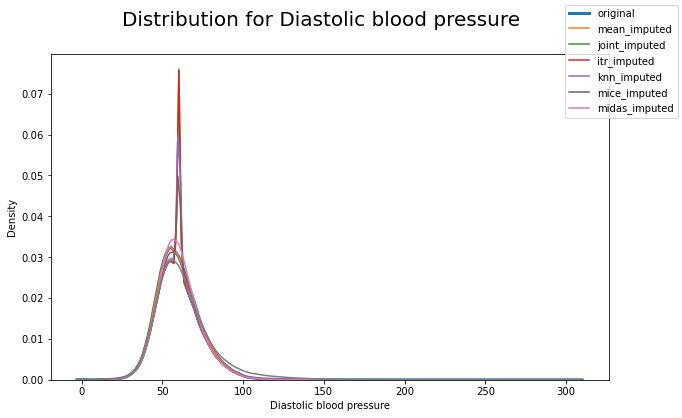

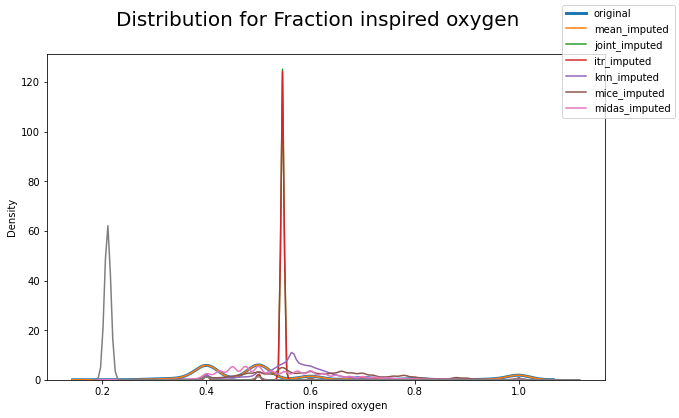

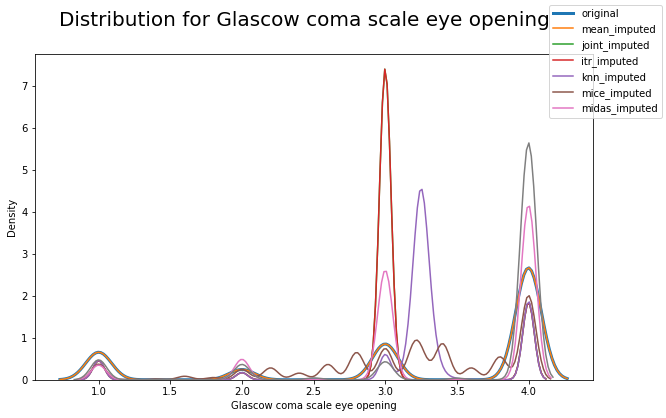

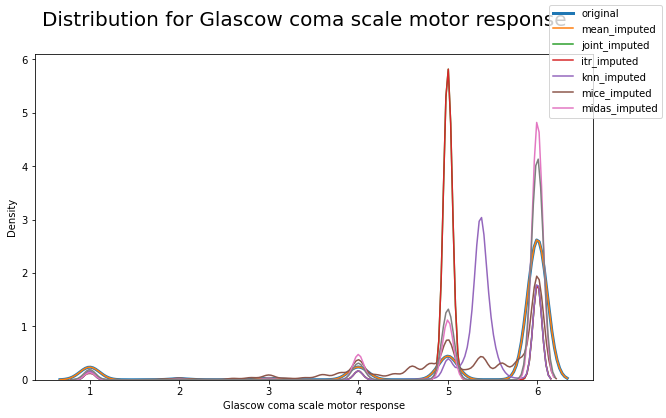

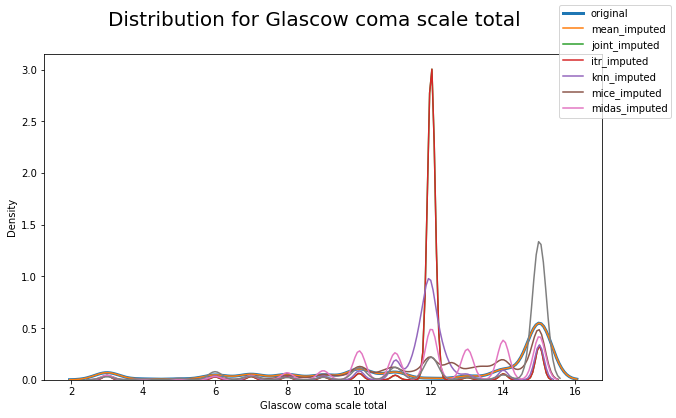

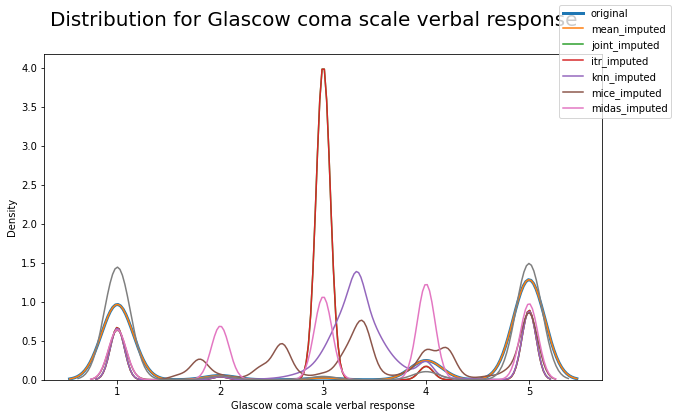

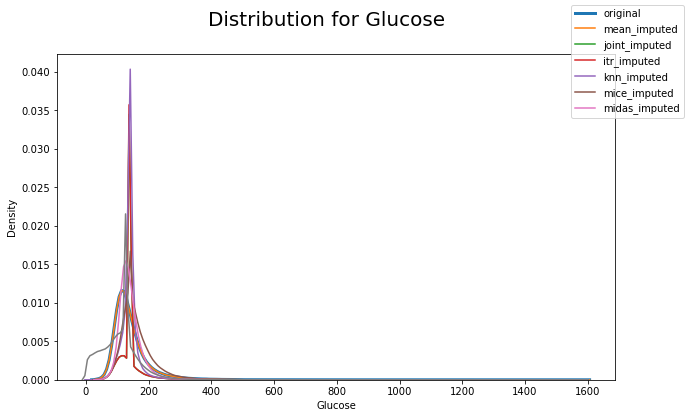

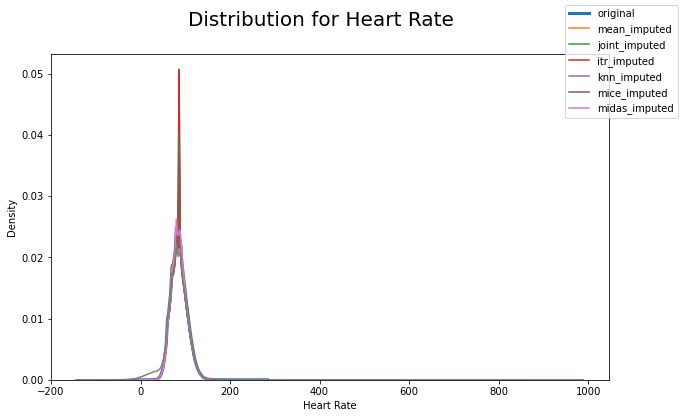

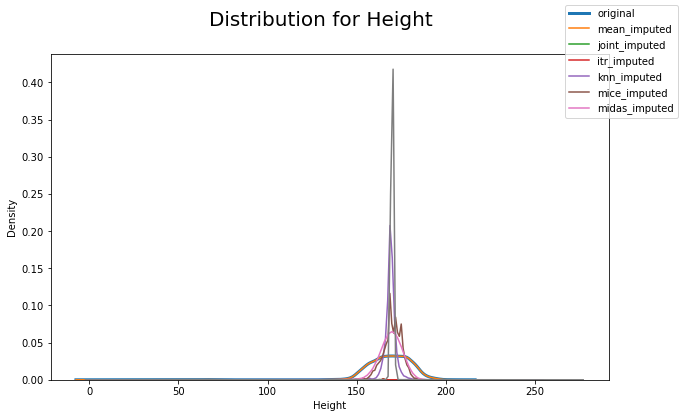

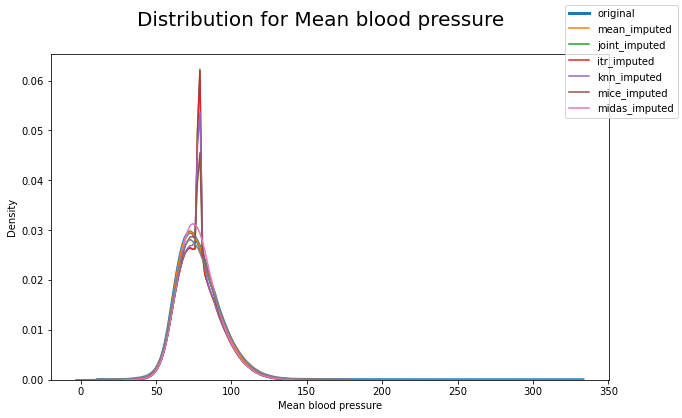

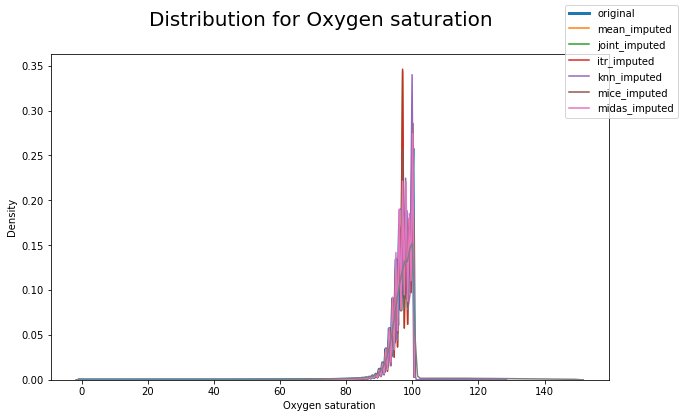

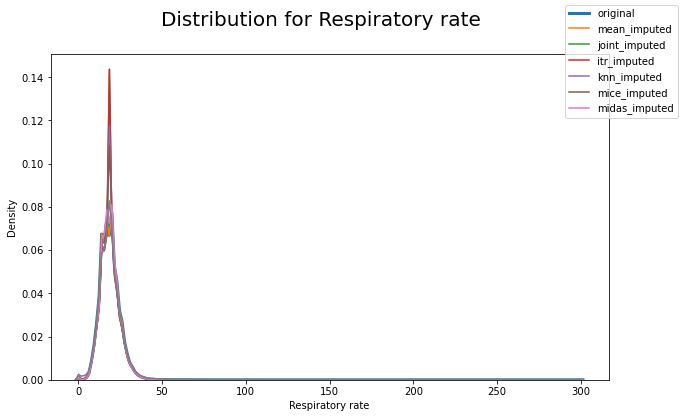

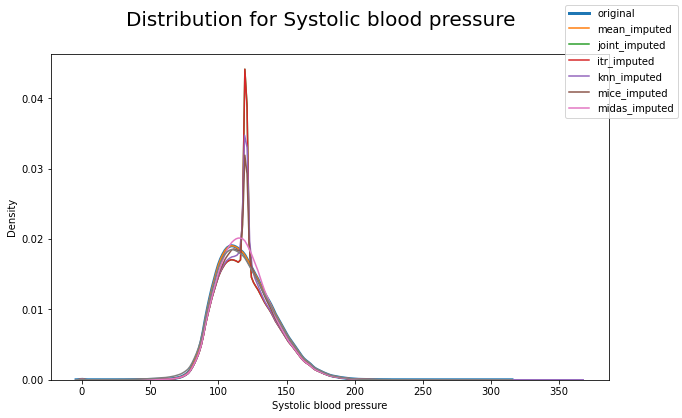

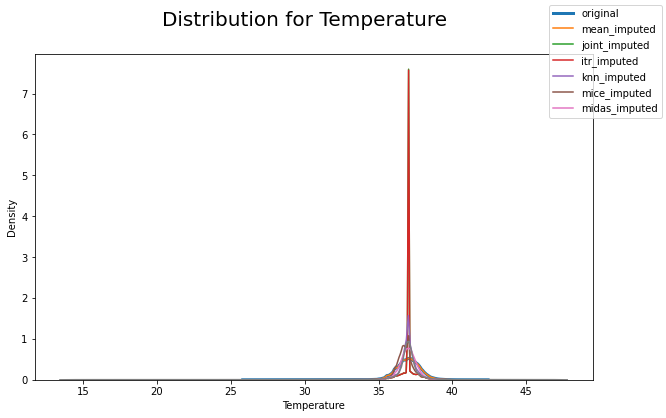

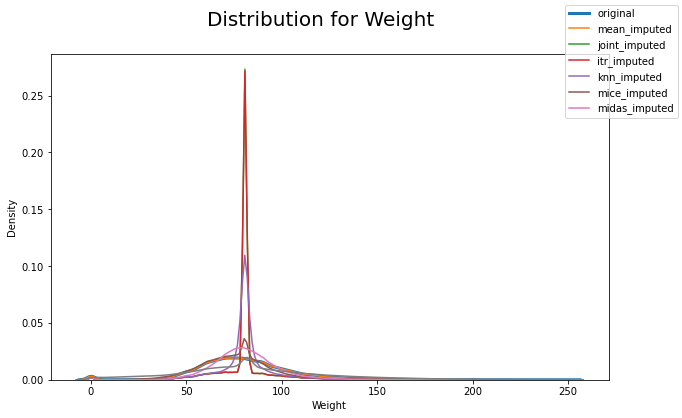

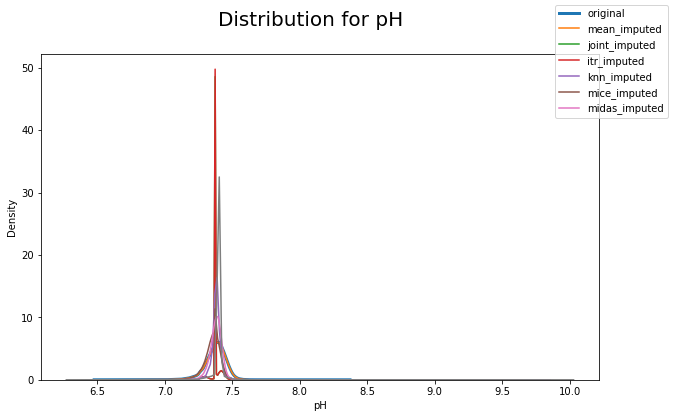

In [31]:
# fig, axes = plt.subplots(4,4, sharex=True, figsize=(40,24))

# count=4
# for i in range(0,4):
#     for x in range(0,4):
#         sn.distplot(data.iloc[:,count], hist=False,  kde_kws=dict(linewidth=5), ax= axes[i,x], axlabel=str(data.columns[count]))
#         sn.distplot(joint_imputed.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(joint_imputed.columns[count]))
#         sn.distplot(mice_imputed_v2.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(mice_imputed_v2.columns[count]))
#         sn.distplot(knn_imputed.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(knn_imputed.columns[count]))
#         sn.distplot(midas_imputed.iloc[:,count], hist=False,  kde_kws=dict(linewidth=3), ax= axes[i,x], axlabel=str(midas_imputed.columns[count]))
#         fig.legend(labels=['original','joint-imputed','mice_imputed_v2','knn_imputed','midas_imputed'])
#         count+=1

# plt.show()


for i in data.columns[4:]:
    fig=plt.figure(figsize=(10,6))
    sn.distplot(data[i], hist=False,  kde_kws=dict(linewidth=3))

    for x in range(len(imputed_data)):
        sn.distplot(imputed_data[x][i], hist=False,  kde_kws=dict(linewidth=1.5))
    fig.legend(labels=['original','mean_imputed', 'joint_imputed', 'itr_imputed','knn_imputed','mice_imputed','midas_imputed'])
    fig.suptitle('Distribution for %s'%(i),fontsize=20)
    plt.show()

### Root mean squared error

In [8]:
rmse_per_predictor_mean = np.sqrt(np.mean((mean_imputed - mean_imputed)**2))
rmse_per_predictor_joint = np.sqrt(np.mean((joint_imputed - mean_imputed)**2))
rmse_per_predictor_knn = np.sqrt(np.mean((knn_imputed - mean_imputed)**2))
rmse_per_predictor_mice = np.sqrt(np.mean((mice_imputed - mean_imputed)**2))
rmse_per_predictor_midas = np.sqrt(np.mean((midas_imputed - mean_imputed)**2))
print('RMSE per predictor:')
print('Mean\tJoint\tknn\tmice\tmidas\tPredictor\n')
for i in range(4,len(rmse_per_predictor_mean)):
    print(str(round(rmse_per_predictor_mean[i], 2)) + '\t' + str(round(rmse_per_predictor_joint[i], 2)) +'\t'  + str(round(rmse_per_predictor_knn[i], 2)) +'\t' + str(round(rmse_per_predictor_mice[i], 2)) +'\t' + str(round(rmse_per_predictor_midas[i], 2)) +'\t' + mean_imputed.columns[i])

RMSE per predictor:
Mean	Joint	knn	mice	midas	Predictor

0.0	0.03	1.93	4.37	13.09	Diastolic blood pressure
0.0	0.0	0.14	0.19	0.33	Fraction inspired oxygen
0.0	0.0	0.51	0.8	0.86	Glascow coma scale eye opening
0.0	0.0	0.75	0.99	0.83	Glascow coma scale motor response
0.0	0.0	2.1	3.0	2.71	Glascow coma scale total
0.0	0.0	0.81	1.55	1.64	Glascow coma scale verbal response
0.0	0.2	45.99	49.91	59.06	Glucose
0.0	0.04	1.67	5.15	16.27	Heart Rate
0.0	0.01	5.53	12.64	11.4	Height
0.0	0.03	2.03	5.0	8.4	Mean blood pressure
0.0	0.01	0.92	1.2	8.09	Oxygen saturation
0.0	0.02	0.85	1.8	3.74	Respiratory rate
0.0	0.05	2.6	6.96	9.81	Systolic blood pressure
0.0	0.0	0.38	0.67	4.04	Temperature
0.0	0.09	14.88	20.74	37.49	Weight
0.0	0.0	0.06	0.07	0.15	pH


### Box plot

In [ ]:
mean_boxplot = mean_imputed.boxplot(column=['Diastolic blood pressure','Fraction inspired oxygen', 'Glucose', 'Heart Rate', 'Height',
                                            'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate','Systolic blood pressure', 
                                            'Temperature', 'Weight', 'pH'], grid=False, rot=90)   

# Classification Performance comparison

### Machine Learning comparison (Logistic regression Baseline)

In [10]:
# Extract the in-hospital mortality data:
Y = pd.read_hdf(data_path + '/vitals_hourly_data_preprocessed.h5', 'Y')[['in_hospital_mortality', 'los']]
Y = Y.sort_index(axis = 0, level = 'icustay_id')
config = json.load(open(resources_path+'/discretizer_config.json', 'r'))
categorical_var = [key for key, value in  config['is_categorical_channel'].items() if value][1:]

# Remove the icustays that were less than 48 hours:
indices_to_remove = []
for i, row in Y.iterrows():
    if row['los'] < 48:
        indices_to_remove.append(i)
        
Y = Y.drop(indices_to_remove, axis = 0)

data['in_hospital_mortality']=Y['in_hospital_mortality']
y= data.pop('in_hospital_mortality')


In [9]:
# ROC Function
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

"""
Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
"""

# Function that plots roc
def plot_roc(classifier,model,X,y,n_splits,):
    cv = KFold(n_splits)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic (ROC): "+model,
    )
    ax.legend(loc="lower right")
    plt.show()

In [8]:
# function that plots the confusion matrix
from sklearn.metrics import *
def plot_confusion(y,y_pred,name):
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix (' + name + ')')

In [7]:
# function for undersample_majority
def undersample_majority(x_train, y_train):
    
    # Separate the positive and negative x/y data:
    pos_features = x_train[y_train == 1]
    neg_features = x_train[y_train == 0]
    pos_labels = y_train[y_train == 1]
    neg_labels = y_train[y_train == 0]
    
    # Count the number of negative data points, and select that many from the positive data points. This means that 
    # positive samples will be 'copied' or repeated and hence occur multiple times in the training data:
    ids = np.arange(len(neg_features))
    choices = np.random.choice(ids, len(pos_features))
    res_neg_features = neg_features[choices]
    res_neg_labels = neg_labels[choices]
    
    # Combine the resamples and negative data points, and shuffle:
    resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
    resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    resampled_features = resampled_features[order]
    resampled_labels = resampled_labels[order]
    return resampled_features, resampled_labels

In [6]:
# Minmax standardization of the continuous variables:
def minmax(x):
    mins = x.min()
    maxes = x.max()
    x_std = (x - mins) / (maxes - mins)
    return x_std

def std_time_since_measurement(x):
    idx = pd.IndexSlice
    x = np.where(x==100, 0, x)
    means = x.mean()
    stds = x.std() + 0.0001
    x_std = (x - means)/stds
    return x_std

### Preprocess data

In [22]:
mean_imputed=pd.read_csv(data_path+'/imputed_data/mean_imputed.csv')
joint_imputed=pd.read_csv(data_path+'/imputed_data/joint_imputed.csv')
itr_imputed=pd.read_csv(data_path+'/imputed_data/itr_imputed(tsm).csv')
knn_imputed=pd.read_csv(data_path+'/imputed_data/knn_imputed.csv')
mice_imputed_2=pd.read_csv(data_path+'/imputed_data/mice_imputed_v2.csv')
midas_imputed=pd.read_csv(data_path+'/imputed_data/midas_imputedv2.csv')

variable_ranges = pd.read_csv(resources_path+ '/variable_ranges.csv', index_col = None)

imputed_data=[mean_imputed, joint_imputed, itr_imputed,knn_imputed, mice_imputed_2, midas_imputed]
imputed_labels=['mean_imputed', 'joint_imputed', 'itr_imputed','knn_imputed','mice_imputed','midas_imputed']

In [23]:
from sklearn.decomposition import PCA
# imputed_data=[mean_imputed,joint_imputed,mice_imputed,mice_imputed_v2,knn_imputed,midas_imputed]
# imputed_labels=['Mean-imputed','joint-imputed','mice_imputed','mice_imputed_v2','knn_imputed','midas_imputed']

for i in range(len(imputed_data)):
    for column in imputed_data[i].columns:

        #Remove outliers
        if column in variable_ranges['LEVEL2'].values:
            row = variable_ranges[variable_ranges['LEVEL2']==column]

            highs=imputed_data[i].index[imputed_data[i][column]>row['OUTLIER HIGH'].values[0]].tolist()
            lows = imputed_data[i].index[imputed_data[i][column]<row['OUTLIER LOW'].values[0]].tolist()
            imputed_data[i].loc[highs,column]=row['IMPUTE'].values[0]
            imputed_data[i].loc[lows,column]=row['IMPUTE'].values[0]
            
        #Min max scaling the values that are not categorical
        if column not in categorical_var:
            imputed_data[i].loc[:, column] = minmax(imputed_data[i].loc[:, column].values)

        # Round Categorial Variables
        if column in categorical_var:
            imputed_data[i].loc[:, column] = np.round(imputed_data[i].loc[:, column].values)



    #One hot encode categorical variables
    #imputed_data[i]= pd.get_dummies(imputed_data[i], columns=categorical_var)

    # PCA
    # pca = PCA(n_components=5)
    # imputed_data[i]=pca.fit_transform(imputed_data[i])


def create_x_matrix(x): # extract the first 48 hours for every icustay.
    zeros = np.zeros((48, x.shape[1]-5))
    x = x.values
    x = x[:48, 5:] # the first four columns are for subject_id, icustay_id, hadm_id and hours_in.
    zeros[0:x.shape[0], :] = x
    return zeros

def create_y_matrix(y):
    y = y['in_hospital_mortality'].to_numpy()
    return y




### Logistic regression (Train test split)

In [25]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict

for i in range(len(imputed_data)):

    # x = np.array(list(imputed_data[i].reset_index().groupby('icustay_id').apply(lambda x: x.values[:, 4:])))
    # x = np.reshape(x, (x.shape[0], -1)).astype('float32')
    # y = np.array(list(Y.groupby('icustay_id').apply(lambda i: i['in_hospital_mortality'].to_numpy())))[:, 0].astype('float32')

    x = np.array(list(imputed_data[i].reset_index().groupby('icustay_id').apply(create_x_matrix)))
    x_shape = x.shape
    x = np.reshape(x, (x.shape[0], -1)).astype('float32')
    y = np.array(list(Y.groupby('icustay_id').apply(create_y_matrix)))[:, 0]

    print(x.shape)
    
    clf_rf = RandomForestClassifier()
    clf_lg = LogisticRegression()
    clf_svc = SVC(gamma='auto')
    u_x,u_y = undersample_majority(x,y)

    for clf, label in zip([clf_rf], [imputed_labels[i]]):

        # cross_val_score returns the cross validation score given X,y data, the scoring method and the number of folds
        f1_macro = cross_val_score(clf, u_x, u_y, scoring='f1_macro', cv=5)
        accuracy = cross_val_score(clf, u_x, u_y, scoring='accuracy', cv=5)
        precision = cross_val_score(clf, u_x, u_y, scoring='precision', cv=5)
        recall = cross_val_score(clf, u_x, u_y, scoring='recall', cv=5)
        
        # cross_val_predict returns the prediction, which is used to create useful plots for comparing performance
        y_pred= cross_val_predict(clf, u_x, u_y, cv=5)
        
        
        print("[%s]"%(label))
        print("f1_macro: %0.3f (+/- %0.3f)" % (f1_macro.mean(),f1_macro.std()))
        print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std()))
        print("Precision: %0.3f (+/- %0.3f)" % (precision.mean(),precision.std()))
        print("Recall: %0.3f (+/- %0.3f)" % (recall.mean(), recall.std() ))
        print()
        
        # Plots the ROC and confusion matrix, this is commented for readibility of code.
        #plot_roc(clf,label,u_x,u_y,n_splits=5)
        #plot_confusion(u_y,y_pred,label)

(17569, 768)
[mean_imputed]
f1_macro: 0.777 (+/- 0.021)
Accuracy: 0.771 (+/- 0.016)
Precision: 0.784 (+/- 0.027)
Recall: 0.762 (+/- 0.015)

(17569, 768)
[joint_imputed]
f1_macro: 0.784 (+/- 0.021)
Accuracy: 0.782 (+/- 0.021)
Precision: 0.796 (+/- 0.020)
Recall: 0.759 (+/- 0.025)

(17569, 3072)
[itr_imputed]
f1_macro: 0.780 (+/- 0.008)
Accuracy: 0.777 (+/- 0.006)
Precision: 0.781 (+/- 0.008)
Recall: 0.772 (+/- 0.019)

(17569, 768)
[knn_imputed]
f1_macro: 0.763 (+/- 0.016)
Accuracy: 0.765 (+/- 0.017)
Precision: 0.772 (+/- 0.023)
Recall: 0.737 (+/- 0.029)

(17569, 768)
[mice_imputed]
f1_macro: 0.767 (+/- 0.012)
Accuracy: 0.765 (+/- 0.013)
Precision: 0.793 (+/- 0.016)
Recall: 0.747 (+/- 0.023)

(17569, 768)
[midas_imputed]
f1_macro: 0.750 (+/- 0.005)
Accuracy: 0.755 (+/- 0.006)
Precision: 0.774 (+/- 0.016)
Recall: 0.722 (+/- 0.010)



# Deep Learning imputation

In [19]:
# Imports:
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from matplotlib import pyplot as plt
import seaborn as sn
import sys
sys.path.append('C:/Users/USER/Anaconda3/Lib/site-packages')
import plot_metrics as PlotMetrics
import tensorflow as tf
import imp
import warnings
warnings.filterwarnings('ignore')

In [ ]:
imputed_data[0].iloc[:,4:]

,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.159609,0.426045,4.0,6.0,15.0,5.0,0.049422,0.425000,0.80797,0.139241,0.970000,0.116667,0.292605,0.679119,0.310000,0.473890
1,0.169381,0.426045,3.0,5.0,12.0,3.0,0.068891,0.421429,0.80797,0.142405,0.960000,0.106667,0.284030,0.801370,0.310000,0.473890
2,0.170467,0.426045,3.0,5.0,12.0,3.0,0.068891,0.414286,0.80797,0.144515,0.950000,0.101111,0.274384,0.756851,0.310000,0.473890
3,0.197068,0.426045,3.0,5.0,12.0,3.0,0.068891,0.400000,0.80797,0.162975,0.935000,0.108333,0.278135,0.726029,0.310000,0.473890
4,0.198697,0.426045,3.0,5.0,12.0,3.0,0.068891,0.385714,0.80797,0.167722,0.915000,0.123333,0.287781,0.667808,0.310000,0.473890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843307,0.267101,0.425458,3.0,5.0,12.0,3.0,0.069426,0.264286,0.80778,0.250000,0.969042,0.063333,0.466238,0.679163,0.322816,0.473926
843308,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.257143,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843309,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.292857,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843310,0.211726,0.425458,4.0,6.0,15.0,5.0,0.069426,0.260714,0.80778,0.212025,0.969042,0.066667,0.411576,0.650687,0.322816,0.473926


In [ ]:
imputed_data[0]

,icustay_id,subject_id,hadm_id,hours_in,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.0,0.275122,0.635573,0.000000,0.159609,0.426045,4.0,6.0,15.0,5.0,0.049422,0.425000,0.80797,0.139241,0.970000,0.116667,0.292605,0.679119,0.310000,0.473890
1,0.0,0.275122,0.635573,0.021277,0.169381,0.426045,3.0,5.0,12.0,3.0,0.068891,0.421429,0.80797,0.142405,0.960000,0.106667,0.284030,0.801370,0.310000,0.473890
2,0.0,0.275122,0.635573,0.042553,0.170467,0.426045,3.0,5.0,12.0,3.0,0.068891,0.414286,0.80797,0.144515,0.950000,0.101111,0.274384,0.756851,0.310000,0.473890
3,0.0,0.275122,0.635573,0.063830,0.197068,0.426045,3.0,5.0,12.0,3.0,0.068891,0.400000,0.80797,0.162975,0.935000,0.108333,0.278135,0.726029,0.310000,0.473890
4,0.0,0.275122,0.635573,0.085106,0.198697,0.426045,3.0,5.0,12.0,3.0,0.068891,0.385714,0.80797,0.167722,0.915000,0.123333,0.287781,0.667808,0.310000,0.473890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843307,1.0,0.287743,0.349587,0.914894,0.267101,0.425458,3.0,5.0,12.0,3.0,0.069426,0.264286,0.80778,0.250000,0.969042,0.063333,0.466238,0.679163,0.322816,0.473926
843308,1.0,0.287743,0.349587,0.936170,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.257143,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843309,1.0,0.287743,0.349587,0.957447,0.196281,0.425458,3.0,5.0,12.0,3.0,0.069426,0.292857,0.80778,0.204412,0.969042,0.066667,0.386489,0.679163,0.322816,0.473926
843310,1.0,0.287743,0.349587,0.978723,0.211726,0.425458,4.0,6.0,15.0,5.0,0.069426,0.260714,0.80778,0.212025,0.969042,0.066667,0.411576,0.650687,0.322816,0.473926


In [20]:
x = np.array(list(imputed_data[0].reset_index().groupby('icustay_id').apply(create_x_matrix)))
print(x.shape)
x_shape = x.shape
x = np.reshape(x, (x.shape[0], -1)).astype('float32')
print(x.shape)
y = np.array(list(Y.groupby('icustay_id').apply(create_y_matrix)))[:, 0]

(17569, 48, 16)
(17569, 768)


### Auto-encoder + LSTM Model

In [21]:
# Autoencoder architecture:
class Autoencoder(tf.keras.Model):
    def __init__(self, output_dim = 16*48):
        super(Autoencoder, self).__init__()
        self.output_dim = output_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units = 256, activation = tf.nn.relu), 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
            tf.keras.layers.Dense(units = 16*48, activation = tf.nn.relu),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units = 128,  activation = tf.nn.relu),
            tf.keras.layers.Dense(units = 256,  activation = tf.nn.relu),
            tf.keras.layers.Dense(units = output_dim,  activation = tf.nn.relu),  
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [22]:
# Initialize the arrays for the results:
y_true_lstm, predictions_lstm, predictions_logreg = [], [], []
loss_train_ae, loss_val_ae = [], []
loss_train_lstm, loss_val_lstm = [], []
acc_train, acc_val, auc_train, auc_val = [], [], [], []

# Stratified 5-fold cross-validation:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
for train_index, test_index in kf.split(x, y):
    
    # Split in training and test set, and split the training further in training and validation sets:
    x_train, x_val, y_train, y_val = train_test_split(x[train_index], y[train_index], test_size=0.125, random_state=0, 
                                            stratify=y[train_index])
    x_test, y_test = x[test_index], y[test_index]
    
    x_train, y_train = undersample_majority(x_train, y_train)
    
    # Initialize the autoencoder:
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
                       loss = tf.keras.losses.MeanSquaredError())
    history_ae = autoencoder.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20, batch_size = 500, 
                                callbacks = tf.keras.callbacks.ModelCheckpoint(filepath = 'ae_encoding', monitor = 'val_loss',
                                                                            verbose = 1, mode = 'max', 
                                                                            save_weights_only = True, save_best_only = True))    
    
    # Load the best model and get the encodings:
    autoencoder.load_weights('ae_encoding')
    enc_train = autoencoder.encoder(x_train)
    enc_val = autoencoder.encoder(x_val)
    enc_test = autoencoder.encoder(x_test)
    print(enc_train)
    enc_train = np.reshape(enc_train, (-1, x_shape[1], x_shape[2]))
    enc_val = np.reshape(enc_val, (-1, x_shape[1], x_shape[2]))
    enc_test = np.reshape(enc_test, (-1, x_shape[1], x_shape[2]))
    
    # Initialize the LSTM and parameters:
    model_module = imp.load_source(os.path.basename(resources_path+'/lstm.py'), resources_path+'/lstm.py')
    lstm = model_module.Network(dim=16, batch_norm=False, dropout=0.3, depth=2, rec_dropout=0.0, task='ihm', batch_size=8)
    lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9), loss='binary_crossentropy', 
                 loss_weights=None, metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')])
    
    # Training:
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='lstm_ae_encoding', monitor='val_auc', 
                                                      verbose=1, mode='max', save_weights_only=True, save_best_only=True)
    history = lstm.fit(x = enc_train, y = y_train, validation_data = (enc_val, y_val), epochs=80, batch_size=8, 
                       callbacks=[model_checkpoint])

    # Make predictions with the LSTM:
    lstm.load_weights('lstm_ae_encoding')
    pred = lstm.predict(enc_test, batch_size=8, verbose=1)
    predictions_lstm.append(list(pred))
    y_true_lstm.append(list(y_test))
    
    # Baseline: logistic regression
    logreg = LogisticRegression(penalty = 'l2', C = 1, random_state = 0)
    logreg.fit(np.reshape(enc_train, (-1, x_shape[1] * x_shape[2])), y_train)
    pred = logreg.predict_proba(np.reshape(enc_test, (-1, x_shape[1] * x_shape[2])))
    predictions_logreg.append(list(pred))
    
#     # Save the loss and other metrics:
    loss_train_ae.append(history_ae.history['loss'])
    loss_val_ae.append(history_ae.history['val_loss'])
    loss_train_lstm.append(history.history['loss'])
    loss_val_lstm.append(history.history['val_loss'])
    acc_train.append(history.history['accuracy'])
    acc_val.append(history.history['val_accuracy'])
    auc_train.append(history.history['auc'])
    auc_val.append(history.history['val_auc'])

Epoch 1/20
5/6 [========================>.....] - ETA: 0s - loss: 0.4591
Epoch 00001: val_loss improved from -inf to 0.18311, saving model to ae_encoding
6/6 [==============================] - 1s 66ms/step - loss: 0.4545 - val_loss: 0.1831
Epoch 2/20
5/6 [========================>.....] - ETA: 0s - loss: 0.4349
Epoch 00002: val_loss improved from 0.18311 to 0.27811, saving model to ae_encoding
6/6 [==============================] - 0s 42ms/step - loss: 0.4276 - val_loss: 0.2781
Epoch 3/20
4/6 [===================>..........] - ETA: 0s - loss: 0.4011
Epoch 00003: val_loss improved from 0.27811 to 0.44038, saving model to ae_encoding
6/6 [==============================] - 0s 40ms/step - loss: 0.3983 - val_loss: 0.4404
Epoch 4/20
5/6 [========================>.....] - ETA: 0s - loss: 0.3732
Epoch 00004: val_loss improved from 0.44038 to 0.61128, saving model to ae_encoding
6/6 [==============================] - 0s 40ms/step - loss: 0.3712 - val_loss: 0.6113
Epoch 5/20
5/6 [===============

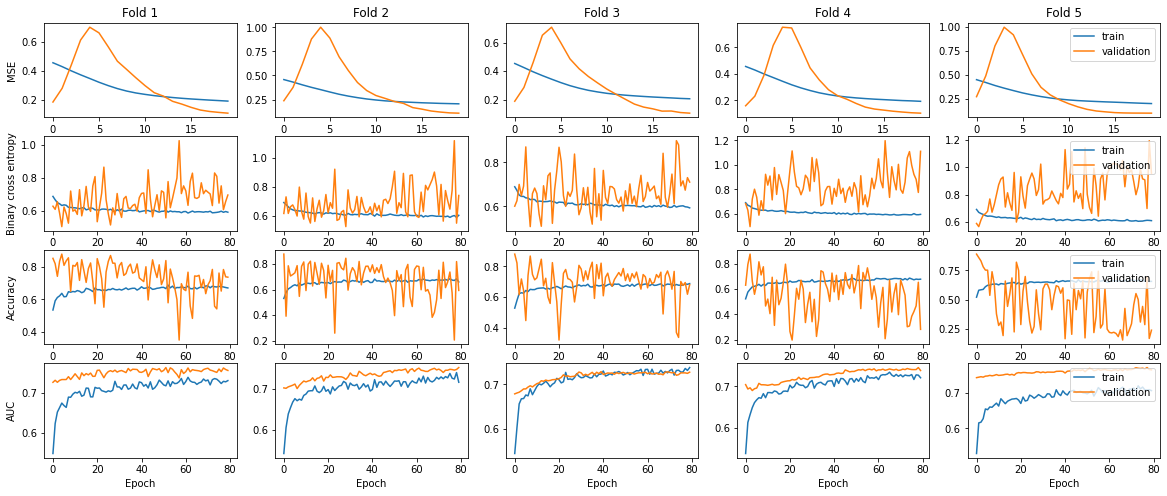

In [23]:
# Look at the loss for every fold:
fig, axs = plt.subplots(4, 5, figsize=(20, 8))
for i in range(5):
    axs[0, i].plot(np.arange(len(loss_train_ae[i])), loss_train_ae[i], label = 'train')
    axs[0, i].plot(np.arange(len(loss_val_ae[i])), loss_val_ae[i], label = 'validation')
    axs[0, i].set_title('Fold ' + str(i + 1))
    
    axs[1, i].plot(np.arange(len(loss_train_lstm[i])), loss_train_lstm[i], label = 'train')
    axs[1, i].plot(np.arange(len(loss_val_lstm[i])), loss_val_lstm[i], label = 'validation')
    
    axs[2, i].plot(np.arange(len(acc_train[i])), acc_train[i], label = 'train')
    axs[2, i].plot(np.arange(len(acc_val[i])), acc_val[i], label = 'validation')
    
    axs[3, i].plot(np.arange(len(auc_train[i])), auc_train[i], label = 'train')
    axs[3, i].plot(np.arange(len(auc_val[i])), auc_val[i], label = 'validation')
    axs[3, i].set_xlabel('Epoch')
    
axs[0, 0].set_ylabel('MSE')
axs[1, 0].set_ylabel('Binary cross entropy')
axs[2, 0].set_ylabel('Accuracy')
axs[3, 0].set_ylabel('AUC')
axs[0, 4].legend(loc = 'upper right')
axs[1, 4].legend(loc = 'upper right')
axs[2, 4].legend(loc = 'upper right')
axs[3, 4].legend(loc = 'upper right')

In [24]:
y_true_lstm_combined = np.concatenate(y_true_lstm)
predictions_lstm_combined = np.concatenate(predictions_lstm)

In [40]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('f1_score:', str(f1_score(y_true_lstm_combined, np.round(predictions_lstm_combined), average='macro')))
print('accuracy_score:', str(accuracy_score(y_true_lstm_combined, np.round(predictions_lstm_combined))))
print('precision_score:', str(precision_score(y_true_lstm_combined, np.round(predictions_lstm_combined))))
print('recall_score:', str(recall_score(y_true_lstm_combined, np.round(predictions_lstm_combined))))


f1_score: 0.5821952572630877
accuracy_score: 0.7161477602595481
precision_score: 0.23915017250771745
recall_score: 0.6229895931882686


Text(123.0, 0.5, 'True label')

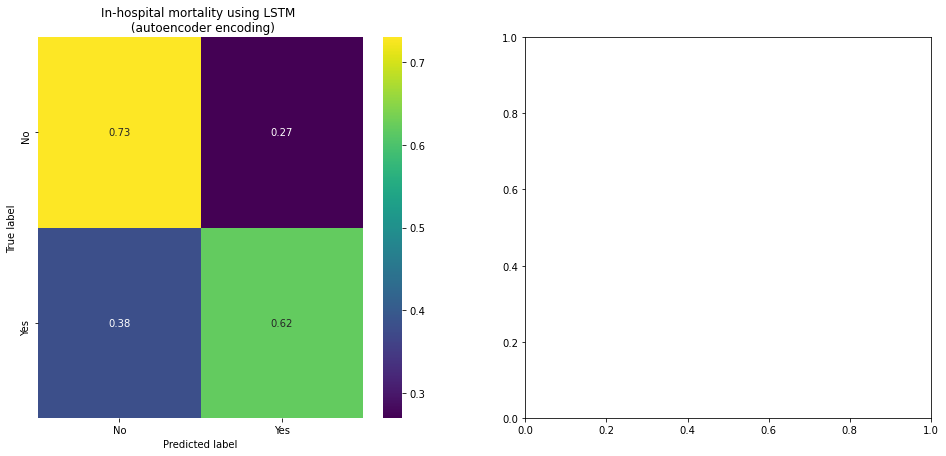

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Confusion matrix for the baseline model:
cm = metrics.confusion_matrix(y_true_lstm_combined, np.round(predictions_lstm_combined), normalize = 'true')
df_cf = pd.DataFrame(np.round(cm, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[0])
ax[0].set_title('In-hospital mortality using LSTM \n (autoencoder encoding)')
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

In [33]:
f1_lstm = metrics.f1_score(y_true_lstm_combined, np.round(predictions_lstm_combined))
f1_lstm

0.34562393386694656

Text(0.5, 1.0, 'ROC curves for in-hospital mortality prediction \n (autoencoder encoding)')

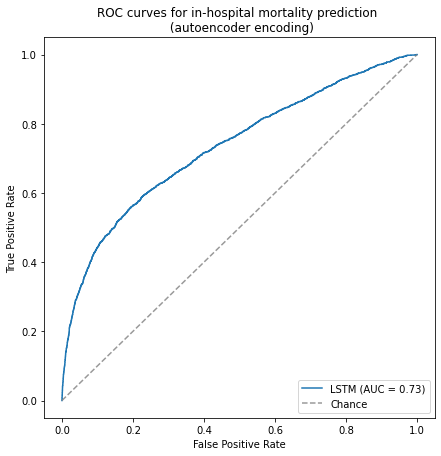

In [29]:
# ROC AUC curve:
roc_auc_lstm = metrics.roc_auc_score(y_true_lstm_combined, predictions_lstm_combined)
fpr_lstm, tpr_lstm, threshold_lstm = metrics.roc_curve(y_true_lstm_combined, predictions_lstm_combined)

fig, ax = plt.subplots(figsize = (7, 7))
ax.plot(fpr_lstm, tpr_lstm, label = 'LSTM (AUC = ' + str(round(roc_auc_lstm, 2)) + ')')
ax.plot([0, 1], [0, 1], linestyle='--', color = 'gray', label = 'Chance', alpha=0.8)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for in-hospital mortality prediction \n (autoencoder encoding)')